In [1]:
import pandas as pd
import json

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from shallowtree.interfaces.full_tree_search import Expander

import rdkit
print(rdkit.__version__)

2022.09.5


## 1. Example of retrosynthetic analysis and scoring

In [16]:
smiles = [
        "CN(C)CC(O)COc1ccc(Nc2nccc(N(Cc3ccccc3)c3cc(Cl)ccc3Cl)n2)cc1",
        "O=C(Nc1n[nH]c2cc(-c3ccccc3)ccc12)C1CC1",
        "O=C(Nc1n[nH]c2nc(-c3ccc(O)c(Br)c3)ccc12)C1CC1",
]

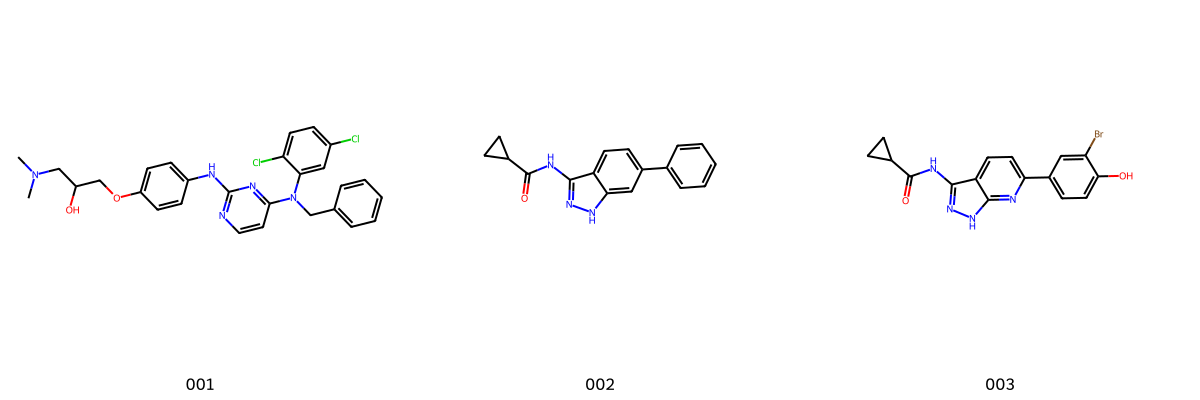

In [23]:
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in smiles if x is not None],
                     legends=[f'{x+1:>03}' for x in range(3)],
                    subImgSize=(400, 400))

In [2]:
# Loading the configuration
expander = Expander(configfile='config.yml')
expander.expansion_policy.select_first()
expander.filter_policy.select_first()
expander.stock.select_first()

In [17]:
# Recover the solution as a Dataframe
df = expander.search_tree(smiles)

In [11]:
df

,SMILES,score,route,BBs
0,CN(C)CC(O)COc1ccc(Nc2nccc(N(Cc3ccccc3)c3cc(Cl)...,0.5,{},[]
1,O=C(Nc1n[nH]c2cc(-c3ccccc3)ccc12)C1CC1,1.0,{1: [['O=C(Nc1n[nH]c2cc(-c3ccccc3)ccc12)C1CC1 ...,"[Nc1n[nH]c2cc(Br)ccc12, OB(O)c1ccccc1, O=C(Cl)..."
2,O=C(Nc1n[nH]c2nc(-c3ccc(O)c(Br)c3)ccc12)C1CC1,1.0,{1: [['O=C(Nc1n[nH]c2nc(-c3ccc(O)c(Br)c3)ccc12...,"[Nc1n[nH]c2nc(Br)ccc12, O=C(Cl)C1CC1, CC1(C)OB..."


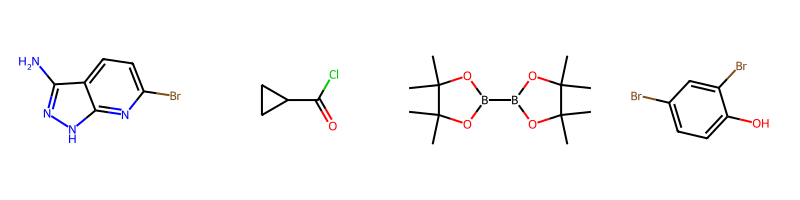

In [26]:
# Output the required starting materials for the predicted synthesis of 003
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in df.BBs[2] if x is not None],
                     molsPerRow=4,
                    subImgSize=(200, 200))

In [24]:
# Output the predicted route for 003 for in json format
route = df.route[2]
print(json.dumps(route, indent=2))

{
  "1": [
    [
      "O=C(Nc1n[nH]c2nc(-c3ccc(O)c(Br)c3)ccc12)C1CC1 => O=C(Nc1n[nH]c2nc(Br)ccc12)C1CC1.CC1(C)OB(c2ccc(O)c(Br)c2)OC1(C)C",
      "Suzuki coupling"
    ]
  ],
  "2": [
    [
      "O=C(Nc1n[nH]c2nc(Br)ccc12)C1CC1 => Nc1n[nH]c2nc(Br)ccc12.O=C(Cl)C1CC1",
      "N-acylation to amide"
    ],
    [
      "CC1(C)OB(c2ccc(O)c(Br)c2)OC1(C)C => CC1(C)OB(B2OC(C)(C)C(C)(C)O2)OC1(C)C.Oc1ccc(Br)cc1Br",
      "Other functional group interconversion"
    ]
  ]
}


## 2. Example of context search

This mode helps to analyze a collection of molecules with a common scaffold (e.g. in a parallel library case) where we are only interested in a single disconnection and the scaffold precursor is assumed to be in stock. In this implementation a single disconnection is available encoded in the 'scaffold' SMILES parameter we provide

In [12]:
smi = 'Clc1ccccc1COC5CC(Nc3n[nH]c4cc(c2ccccc2)ccc34)C5'
scaffold = '[*]-c1n[nH]c2cc(-c3ccccc3)ccc12'

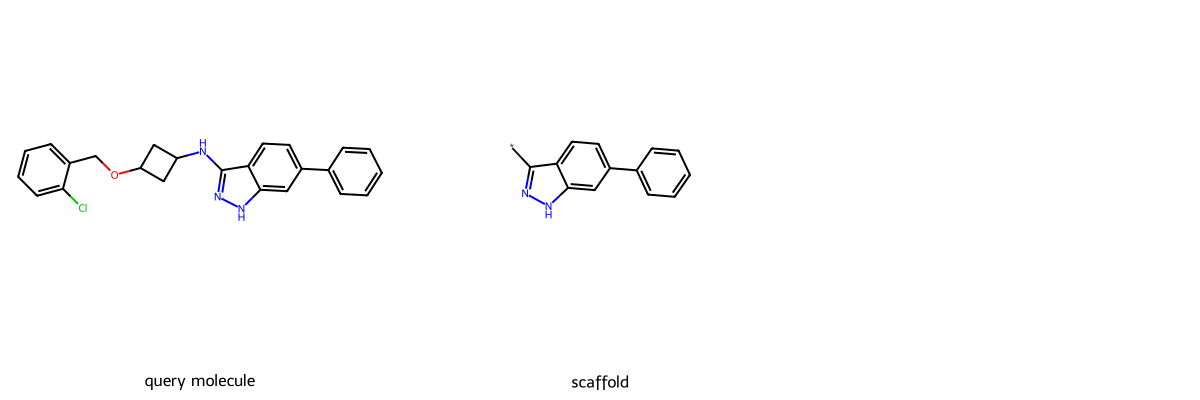

In [13]:
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in [smi, scaffold]],
                     legends=['query molecule', 'scaffold'],
                    subImgSize=(400, 400))

In [14]:
# We have already set up the Expander
# smi needs to be passed as a list
df = expander.context_search([smi], scaffold_str=scaffold)

In [8]:
df

,SMILES,score,route,BBs
0,Clc1ccccc1COC5CC(Nc3n[nH]c4cc(c2ccccc2)ccc34)C5,1.0,{1: [['Clc1ccccc1COC1CC(Nc2n[nH]c3cc(-c4ccccc4...,"[Clc1ccccc1CBr, NC1CC(O)C1, Clc1n[nH]c2cc(-c3c..."


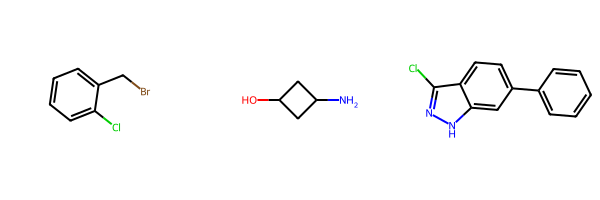

In [10]:
# required starting materials
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in df.BBs[0] if x is not None],
                    subImgSize=(200, 200))

In [11]:
# predicted route
route = df.route[0]
print(json.dumps(route, indent=2))

{
  "1": [
    [
      "Clc1ccccc1COC1CC(Nc2n[nH]c3cc(-c4ccccc4)ccc23)C1 => NC1CC(OCc2ccccc2Cl)C1.Clc1n[nH]c2cc(-c3ccccc3)ccc12",
      "N-arylation with Ar-X"
    ]
  ],
  "2": [
    [
      "NC1CC(OCc2ccccc2Cl)C1 => Clc1ccccc1CBr.NC1CC(O)C1",
      "O-substitution"
    ]
  ]
}
